In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import openpyxl
import csv
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score

import fiona
from shapely.geometry import Point
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import libpysal as ps
import contextily as cx

In [2]:
def ohe_cols(data, ohe_list):
    """
    returns a dataframe with the given features 
    one hot encoded
    """
    ohe_dataframe = pd.DataFrame(index=np.arange(data.shape[0]))
    for col in ohe_list:
        enc = OneHotEncoder(handle_unknown='ignore')
        ohe_dataframe = ohe_dataframe.join(pd.DataFrame(enc.fit_transform(data[[col]]).toarray(), 
                                    columns = enc.get_feature_names_out()).set_index(data.index))
    return ohe_dataframe

## Importing Data into Pandas ##

In [3]:
crashes = pd.read_csv("crash_data_2009.csv", dtype=object)

#### Crashes Dataframe

In [4]:
crashes

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,...,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date
0,3858022,1005,P379,2C,not chp,>250000,1005,fresno,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-02-03,17:11:00,2009-04-27
1,3899441,9120,17248,NaN,2200 thru 0559,2500 to 10000,0801,del norte,0,chp state highway,...,0,0,0,NaN,NaN,NaN,NaN,2009-02-28,01:45:00,2009-11-02
2,3899442,9530,19005,NaN,0600 thru 1359,>250000,1942,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.86465,-118.28533,2009-02-09,10:20:00,2010-01-14
3,3899445,9530,19284,NaN,1400 thru 2159,>250000,1942,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.7912,-118.2823,2009-02-18,15:50:00,2010-01-13
4,3899446,9530,19289,NaN,1400 thru 2159,25000 to 50000,1939,los angeles,0,chp state highway,...,0,0,0,NaN,NaN,33.8845,-118.3526,2009-02-11,17:35:00,2010-01-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426223,5051991,3610,50717,SBPD,not chp,100000 to 250000,3610,san bernardino,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-12-21,08:26:00,2011-02-17
426224,5051995,3610,50640,B,not chp,100000 to 250000,3610,san bernardino,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-12-21,16:21:00,2011-02-17
426225,5051996,3610,50165,3610,not chp,100000 to 250000,3610,san bernardino,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-12-24,09:04:00,2011-02-18
426226,5051999,3610,50705,NaN,not chp,100000 to 250000,3610,san bernardino,0,not chp,...,0,0,0,NaN,NaN,NaN,NaN,2009-12-21,19:14:00,2011-02-17


In [5]:
coords = crashes.dropna(subset=["longitude", "latitude"]).reset_index(drop=True)

In [6]:
for county in coords["county_location"].unique():
    print(county,":",coords[coords["county_location"] == county].shape[0])

los angeles : 35488
butte : 940
merced : 1470
san francisco : 157
sacramento : 5671
colusa : 148
kern : 3846
san bernardino : 4518
madera : 909
riverside : 7026
san luis obispo : 1915
tulare : 1665
orange : 7644
kings : 660
santa barbara : 2282
lake : 515
stanislaus : 2817
placer : 1697
ventura : 3261
san joaquin : 3734
imperial : 610
san diego : 4900
sonoma : 1225
el dorado : 1391
shasta : 315
tuolumne : 405
fresno : 1314
san benito : 327
alameda : 6841
marin : 758
santa clara : 5542
siskiyou : 102
santa cruz : 2075
calaveras : 454
tehama : 254
nevada : 781
napa : 334
mono : 164
solano : 393
monterey : 1606
modoc : 11
amador : 291
contra costa : 927
humboldt : 276
yuba : 361
sierra : 24
inyo : 137
san mateo : 290
mendocino : 82
sutter : 223
yolo : 139
mariposa : 28
trinity : 49
alpine : 42
lassen : 28
glenn : 43
plumas : 4
del norte : 3


In [7]:
coords_gdf = gpd.GeoDataFrame(coords, geometry=gpd.points_from_xy(coords["longitude"], coords["latitude"]))

In [8]:
coords_gdf = coords_gdf.set_crs("EPSG:4326")

In [9]:
coords_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Map of California Collision GPS Data')

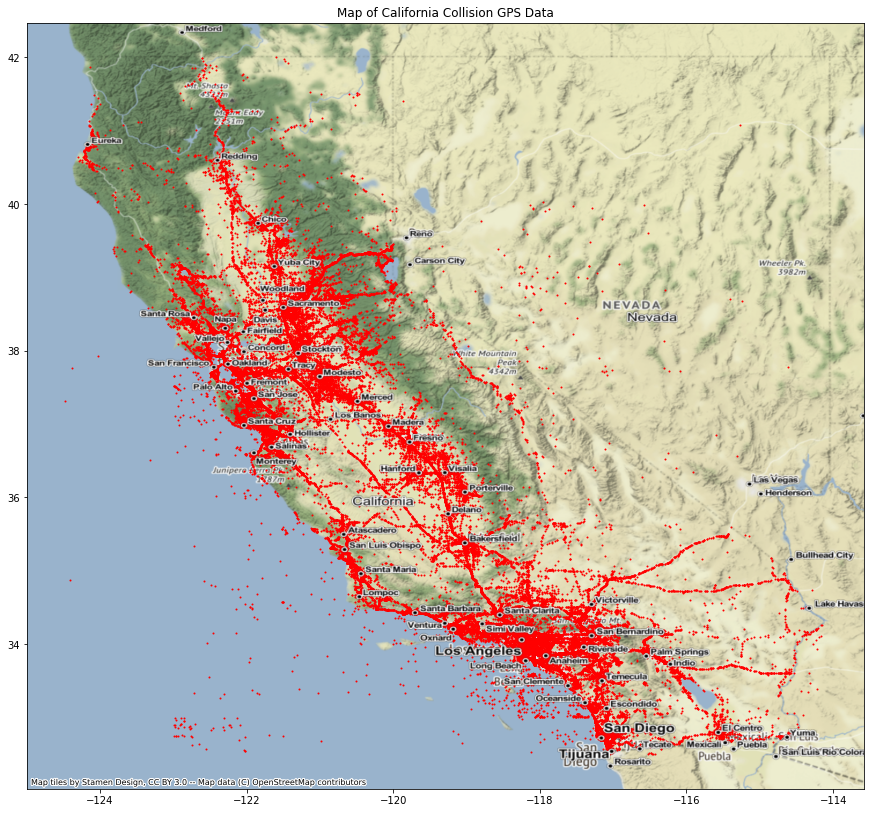

In [10]:
ax = coords_gdf.plot(figsize=(15, 15), markersize=1, color="red")
cx.add_basemap(ax=ax, crs=coords_gdf.crs.to_string(), source=cx.providers.Stamen.Terrain)
cx.add_basemap(ax=ax, crs=coords_gdf.crs.to_string(), source=cx.providers.Stamen.TonerLabels)
plt.title("Map of California Collision GPS Data")
#plt.savefig("collisions_map.png", bbox_inches='tight')

#### Adding new columns

###### Adding month and hour column

In [11]:
def monthCol(df, col):
    month = df[col].str.extract(r"^\d{4}\-0(\d)|^\d{4}\-(\d{2})", expand=False).values
    return pd.Series(month[month == month].astype(int))

def hourCol(df, col):
    hour = df[col].str.extract(r"(^[^0]\d)|^0(\d)", expand=False).values
    return pd.Series(hour[hour == hour]).astype(int)

crashes["crash_month"] = monthCol(crashes, "collision_date")
crashes["crash_hour"] = hourCol(crashes, "collision_time")

## Preprocessing

###### Preprocessing (removing rows that have NaN for the given feature)

In [12]:
clean_list = ["county_location", "population", "weather_1", "road_surface", "collision_severity", 
              "lighting", "party_count", "injured_victims", "killed_victims", "crash_hour", 
              "crash_month", "type_of_collision", "hit_and_run", "pedestrian_action", 
              "pedestrian_collision", "pcf_violation_category", "motor_vehicle_involved_with"]

def removeNaN(df, clean_list):
    """
    removes NaN from given features in df
    """
    copy = df.copy()
    return copy.dropna(subset=clean_list).reset_index(drop=True)
crashes = removeNaN(crashes, clean_list)

###### Preprocessing (converting numeric features into int)

In [13]:
numerical_features = ["party_count", "injured_victims", "killed_victims", "crash_hour", "crash_month"]

def convertToInt(df, numerical_features):
    """
    converts numerical_features 
    in df to type int
    """
    copy = df.copy()
    for f in numerical_features:
        if copy[f].dtype != "float64":
            copy[f] = crashes[f].astype(int)
    return copy
crashes = convertToInt(crashes, numerical_features)

###### Converting "population" to say whether its greater or less than 100000

In [14]:
def populationConvert(df):
    """
    converts population to state whether
    the area of a crash has >100000 population
    or <100000 population
    """
    copy = df.copy()
    copy["population"] = copy["population"].str.replace("unincorporated", "1000")
    copy_pop = copy["population"].str.extract(r"(\d+)\s\w.+|\>(\d+)|\<(\d+)|[^\>\<](\d+)", expand=False).values
    copy["population"] = pd.Series(copy_pop[copy_pop == copy_pop].astype(int)).apply(lambda num: ">100000" if num>100000 else "<100000")
    return copy
crashes = populationConvert(crashes)

#### Functions for creating feature dataframe

In [15]:
# ohe_list is the list of columns we want one-hot encoded
ohe_list = ["population", "weather_1", "road_surface", "lighting"]

# features is the list of non-one-hot encoded features
features = ["party_count", "crash_hour", "crash_month"]

# complete list of features being used for creating feature dataframe
model_feature_list = ohe_list + features

def get_feature(df, feature):
    """
    returns given feature from df as a series
    """
    return df[feature]

def create_feature_df(df, ohe_list, features):
    """
    creates a feature dataframe of df according to
    the ohe_list and features list (above)
    """
    copy = df.copy().reset_index(drop=True)
    feature_df = ohe_cols(copy, ohe_list)#.reset_index(drop=True)
    for f in features:
        feature_df = feature_df.join(get_feature(df, f))
    return feature_df

In [16]:
# this is what we would use train_test_split on and input into a machine learning model
create_feature_df(crashes, ohe_list, features).head(3)

,population_<100000,population_>100000,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,road_surface_dry,...,road_surface_snowy,road_surface_wet,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,party_count,crash_hour,crash_month
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,17.0,2
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0,2
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2,10.0,2


In [17]:
crashes.loc[:, model_feature_list]

,population,weather_1,road_surface,lighting,party_count,crash_hour,crash_month
0,>100000,clear,dry,daylight,2,17.0,2
1,<100000,clear,dry,dark with no street lights,1,1.0,2
2,>100000,raining,wet,daylight,2,10.0,2
3,>100000,clear,dry,daylight,3,15.0,2
4,<100000,cloudy,dry,dusk or dawn,3,17.0,2
...,...,...,...,...,...,...,...
403246,>100000,clear,dry,daylight,2,8.0,12
403247,<100000,clear,dry,daylight,2,16.0,12
403248,>100000,clear,dry,daylight,2,9.0,12
403249,>100000,clear,dry,daylight,2,19.0,12


#### Visualizing the dataset

In [18]:
ca_counties = gpd.read_file("CA_Counties")

In [19]:
ca_counties["NAME"] = ca_counties["NAME"].str.lower()
ca_counties = ca_counties.sort_values("NAME", ascending=True)
ca_counties.head(3)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
41,06,001,01675839,06001,alameda,Alameda County,06,H1,G4020,488,41860,36084,A,1914242789,212979931,+37.6471385,-121.9124880,"POLYGON ((-13612246.763 4538150.085, -13612346..."
25,06,003,01675840,06003,alpine,Alpine County,06,H1,G4020,None,None,None,A,1912292633,12557304,+38.6217831,-119.7983522,"POLYGON ((-13366503.508 4678946.015, -13366492..."
50,06,005,01675841,06005,amador,Amador County,06,H1,G4020,None,None,None,A,1539933576,29470568,+38.4435501,-120.6538563,"POLYGON ((-13472697.863 4647652.232, -13472697..."


In [20]:
def map_value_sum(gdf, col):
        """
        maps the sum of given column for
        county. uses quantile scheme with k=6 
        """
        copy = gdf.copy()
        copy[col+"_sum"] = crashes.groupby("county_location").agg({col: "sum"}).set_index(copy.index.values)
        copy.plot(column=col+"_sum", figsize=(10,10), legend=True, cmap="YlOrRd", scheme="quantiles", k=6)
        plt.title(f"Map of {col} sum")
        
def map_value(gdf, col):
        """
        maps the given column for
        county. uses quantile scheme with k=6 
        """
        copy = gdf.copy()
        copy[col] = crashes.groupby("county_location").agg({col: "max"}).set_index(copy.index.values)
        copy.plot(column=col, figsize=(10,10), legend=True, cmap="YlOrRd", scheme="quantiles", k=6)
        plt.title(f"Map of {col}")

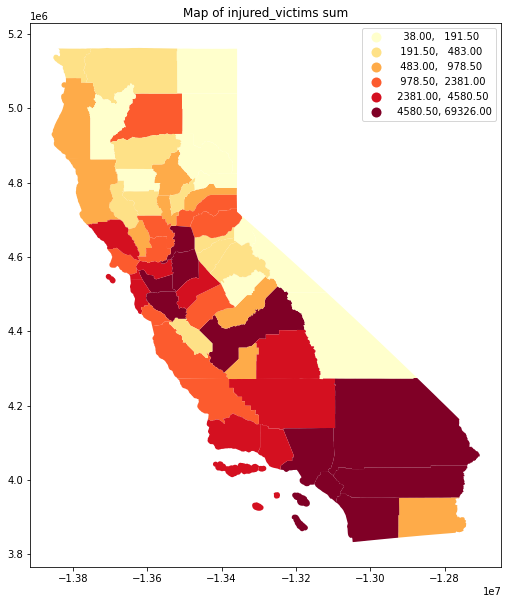

In [21]:
map_value_sum(ca_counties, "injured_victims")

## Can a model predict whether a crash occurence resulted in severe injuries?
#### Based on given information, can you predict whether a crash had severe injuries or not?

I will be creating a classification model to predict whether a model resulted in severe injuries, where:

* 1 = crash had severe injuries
* 0 = crash didn't have severe injuries

based on the assumption that information isn't already available. For this question I will be looking at crashes in Contra Costa County, and later compare results across different counties in the Bay Area.

To answer this question, we'll use the `injured_victims`, `killed_victims`, and `collision_severity` columns as information for knowing the "true" class of each crash, and
therefore won't use them in the training of our model.

The purpose of this model is to see if one can classify a crash as "severe" given only certain information available (otherwise if the above information was available then classification wouldn't be needed).

Crash data relies on the reporting police officer to note down all crash information, but as seen from reported crashes in `crashes` there are often cases where data is missing. This model could be used in instances where `injured_victims`, `killed_victims`, and `collision_severity` may not be available.

###### Adding a new column to `crashes` dataframe that states whether a crash had severe injuries or not

In [22]:
crashes["severe_injuries"] = (crashes["killed_victims"] + crashes["injured_victims"]).apply(lambda num: 1 if num > 0 else 0)

###### Creating a `contra_costa` dataframe

In [23]:
contra_costa = crashes[crashes["county_location"] == "contra costa"].reset_index(drop=True)
contra_costa.head(3)

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,county_location,special_condition,beat_type,...,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date,crash_month,crash_hour,severe_injuries
0,3982945,713,K38,NaN,not chp,<100000,0713,contra costa,0,not chp,...,NaN,NaN,NaN,NaN,2009-01-12,15:26:00,2009-09-16,1,15.0,0
1,3989833,700,61366,57,not chp,<100000,0734,contra costa,0,not chp,...,NaN,NaN,NaN,NaN,2009-01-03,02:19:00,2009-09-09,1,15.0,0
2,3990654,700,52040,057,not chp,<100000,0734,contra costa,0,not chp,...,NaN,NaN,NaN,NaN,2009-01-07,14:25:00,2009-09-10,1,4.0,0


#### EDA

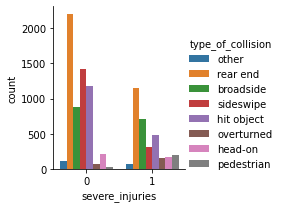

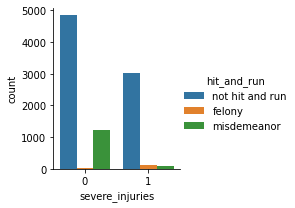

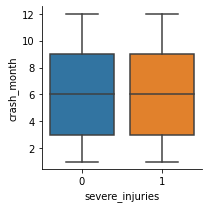

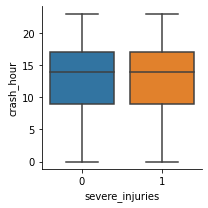

In [24]:
contra_costa_eda = contra_costa.copy(); 

sns.catplot(contra_costa_eda, x="severe_injuries", hue="type_of_collision", kind="count", height=3)
sns.catplot(contra_costa_eda, x="severe_injuries", hue="hit_and_run", kind="count", height=3)
#sns.catplot(contra_costa_eda, x="severe_injuries", hue="motor_vehicle_involved_with", kind="count", height=3)
sns.catplot(contra_costa_eda, x="severe_injuries", y="crash_month", kind="box", height=3)
sns.catplot(contra_costa_eda, x="severe_injuries", y="crash_hour", kind="box", height=3)

In [25]:
contra_costa["pedestrian_action"].unique()

array(['no pedestrian involved', 'crossing in intersection crosswalk',
       'in road', 'crossing not in crosswalk', 'not in road',
       'crossing non-intersection crosswalk'], dtype=object)

In [26]:
contra_costa["motor_vehicle_involved_with"].unique()

array(['other object', 'parked motor vehicle', 'other motor vehicle',
       'fixed object', 'bicycle', 'motor vehicle on other roadway',
       'pedestrian', 'non-collision', 'animal', 'train'], dtype=object)

In [27]:
contra_costa["pcf_violation_category"].unique()

array(['speeding', 'dui', 'other than driver (or pedestrian)',
       'improper passing', 'automobile right of way',
       'other hazardous violation', 'brakes', 'unknown',
       'improper turning', 'unsafe lane change', 'other equipment',
       'wrong side of road', 'traffic signals and signs',
       'unsafe starting or backing', 'following too closely',
       'pedestrian right of way', 'pedestrian violation',
       'hazardous parking', 'other improper driving', 'impeding traffic'],
      dtype=object)

In [28]:
contra_costa_ohe = ohe_cols(contra_costa, clean_list)
contra_costa_ohe["severe_injuries"] = contra_costa["severe_injuries"]

pd.options.display.max_columns = None
contra_costa_ohe.corr().loc[["severe_injuries"], :]

,county_location_contra costa,population_<100000,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_wind,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,collision_severity_fatal,collision_severity_other injury,collision_severity_pain,collision_severity_property damage only,collision_severity_severe injury,lighting_dark with no street lights,lighting_dark with street lights,lighting_dark with street lights not functioning,lighting_daylight,lighting_dusk or dawn,party_count_1,party_count_2,party_count_3,party_count_4,party_count_5,party_count_6,party_count_7,party_count_8,party_count_9,party_count_10,injured_victims_0,injured_victims_1,injured_victims_2,injured_victims_3,injured_victims_4,injured_victims_5,injured_victims_6,injured_victims_7,injured_victims_9,killed_victims_0,killed_victims_1,killed_victims_2,crash_hour_0.0,crash_hour_1.0,crash_hour_2.0,crash_hour_3.0,crash_hour_4.0,crash_hour_5.0,crash_hour_6.0,crash_hour_7.0,crash_hour_8.0,crash_hour_9.0,crash_hour_10.0,crash_hour_11.0,crash_hour_12.0,crash_hour_13.0,crash_hour_14.0,crash_hour_15.0,crash_hour_16.0,crash_hour_17.0,crash_hour_18.0,crash_hour_19.0,crash_hour_20.0,crash_hour_21.0,crash_hour_22.0,crash_hour_23.0,crash_month_1,crash_month_2,crash_month_3,crash_month_4,crash_month_5,crash_month_6,crash_month_7,crash_month_8,crash_month_9,crash_month_10,crash_month_11,crash_month_12,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,type_of_collision_other,type_of_collision_overturned,type_of_collision_pedestrian,type_of_collision_rear end,type_of_collision_sideswipe,hit_and_run_felony,hit_and_run_misdemeanor,hit_and_run_not hit and run,pedestrian_action_crossing in intersection crosswalk,pedestrian_action_crossing non-intersection crosswalk,pedestrian_action_crossing not in crosswalk,pedestrian_action_in road,pedestrian_action_no pedestrian involved,pedestrian_action_not in road,pedestrian_collision_0,pedestrian_collision_1,pcf_violation_category_automobile right of way,pcf_violation_category_brakes,pcf_violation_category_dui,pcf_violation_category_following too closely,pcf_violation_category_hazardous parking,pcf_violation_category_impeding traffic,pcf_violation_category_improper passing,pcf_violation_category_improper turning,pcf_violation_category_other equipment,pcf_violation_category_other hazardous violation,pcf_violation_category_other improper driving,pcf_violation_category_other than driver (or pedestrian),pcf_violation_category_pedestrian right of way,pcf_violation_category_pedestrian violation,pcf_violation_category_speeding,pcf_violation_category_traffic signals and signs,pcf_violation_category_unknown,pcf_violation_category_unsafe lane change,pcf_violation_category_unsafe starting or backing,pcf_violation_category_wrong side of road,motor_vehicle_involved_with_animal,motor_vehicle_involved_with_bicycle,motor_vehicle_involved_with_fixed object,motor_vehicle_involved_with_motor vehicle on other roadway,motor_vehicle_involved_with_non-collision,motor_vehicle_involved_with_other motor vehicle,motor_vehicle_involved_with_other object,motor_vehicle_involved_with_parked motor vehicle,motor_vehicle_involved_with_pedestrian,motor_vehicle_involved_with_train,severe_injuries
severe_injuries,NaN,NaN,0.029405,-0.025792,0.011039,-0.011731,-0.012563,-0.007542,0.004087,0.01207,0.006682,-0.005187,0.115059,0.443039,0.744497,-1.0,0.186578,0.000737,-0.03479,-0.004956,0.026471,0.01063,-0.014511,-0.041074,0.062534,0.031965,0.019511,0.012955,0.008184,-0.007542,0.014222,-0.007542,-0.990073,0.806448,0.354651,0.176189,0.100832,0.040242,0.024636,0.020114,0.014222,-0.115059,0.114165,0.014222,-0.001286,0.00687,-0.007276,-0.00336,0.005261,-0.003937,-0.021093,0.002341,-0.007515,0.003101,0.002355,-0.000829,-0.010386,0.020234,-0.005167,0.003852,0.004302,0.001745,-0.007526,-0.0118,0.015096,-0.007679,0.011005,0.00759,0.000774,-0.001509,-0.008437,-0.000518,0.019425,-0.001265,0.018618,0.003381

##### From our correlation matrix, we can see that certain categorical features seem to have a high correlation with whether a crash had severe injuries or not.
##### Below is our final list of columns we'll One-Hot Encode, and non-categorical features we'll use.

In [29]:
ohe_list = ["type_of_collision", "hit_and_run", "pedestrian_action", "pedestrian_collision", "pcf_violation_category", "motor_vehicle_involved_with"]
features = ["party_count", "crash_hour", "crash_month"]

In [30]:
pd.options.display.max_columns = 6

In [31]:
create_feature_df(contra_costa.drop(columns=["severe_injuries"]).reset_index(drop=True), ohe_list, features)

,type_of_collision_broadside,type_of_collision_head-on,type_of_collision_hit object,...,party_count,crash_hour,crash_month
0,0.0,0.0,0.0,...,1,15.0,1
1,0.0,0.0,0.0,...,2,15.0,1
2,1.0,0.0,0.0,...,2,4.0,1
3,0.0,0.0,0.0,...,2,6.0,1
4,1.0,0.0,0.0,...,2,14.0,1
...,...,...,...,...,...,...,...
9319,0.0,0.0,1.0,...,2,23.0,12
9320,1.0,0.0,0.0,...,2,7.0,12
9321,0.0,1.0,0.0,...,3,17.0,11
9322,0.0,0.0,0.0,...,1,17.0,10


In [32]:
X = create_feature_df(contra_costa.drop(columns=["severe_injuries"]).reset_index(drop=True), ohe_list, features)
y = contra_costa["severe_injuries"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### A Support Vector Machine (SVM) model will be used to classify a crash as either a severe one or not (where a severe crash implies an occurence of severe injuries)

In [33]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [34]:
accuracy_score(y_train, svc.predict(X_train))

0.6868296868296868

In [35]:
accuracy_score(y_test, svc.predict(X_test))

0.6795366795366795

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, svc.predict(X_train))

array([[4552,   29],
       [2161,  251]], dtype=int64)

#### Hyperparameter Tuning using Grid Search Cross Validation

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
parameters_svc = {
    "C": [0.001, 0.01, 0.1, 1],
    "kernel": ["linear", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
    "class_weight": [None, "balanced"]
}
gridsearch_svc = GridSearchCV(SVC(), parameters_svc,
                          scoring=["accuracy"], cv=5, refit="accuracy")
gridsearch_svc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             refit='accuracy', scoring=['accuracy'])

In [39]:
gridsearch_svc.best_params_

{'C': 0.1, 'class_weight': None, 'gamma': 'scale', 'kernel': 'linear'}

In [40]:
svc_best = SVC(C=0.1, gamma="scale", kernel="linear")
svc_best.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [41]:
accuracy_score(y_train, svc_best.predict(X_train))

0.7108537108537109

In [42]:
accuracy_score(y_test, svc_best.predict(X_test))

0.7018447018447018

#### We'll now try using this model for other counties in the Bay Area, and then compare results

In [43]:
bay_area_counties_list = ["alameda", "contra costa", "marin", "napa", "san francisco", "san mateo", "santa clara", "solano", "sonoma"]

In [44]:
county_results = dict()

for county in bay_area_counties_list:
    county_df = crashes[crashes["county_location"] == county].reset_index(drop=True)
    X_county = create_feature_df(county_df.drop(columns=["severe_injuries"]).reset_index(drop=True), ohe_list, features)
    y_county = county_df["severe_injuries"]
    X_train_county, X_test_county, y_train_county, y_test_county = train_test_split(X_county, y_county, test_size=0.25, random_state=42)
    svc_county = SVC(C=0.1, gamma="scale", kernel="linear")
    svc_county.fit(X_train_county, y_train_county)
    county_results[county] = accuracy_score(y_test_county, svc_county.predict(X_test_county))

county_results

{'alameda': 0.7538775510204082,
 'contra costa': 0.7018447018447018,
 'marin': 0.6945668135095447,
 'napa': 0.710997442455243,
 'san francisco': 0.7740841248303935,
 'san mateo': 0.7246891651865008,
 'santa clara': 0.6878926327812679,
 'solano': 0.696078431372549,
 'sonoma': 0.6611764705882353}

In [45]:
bay_area_counties = gpd.read_file("Bay_Area_Counties")

In [46]:
bay_area_counties.head(3)

,county,fipsstco,objectid,geometry
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156..."
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505..."
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711..."


In [47]:
data = {"county_location": list(county_results.keys()), "model_accuracy": list(county_results.values())}
county_results_df = pd.DataFrame(data=data).set_index(bay_area_counties.index.values)
county_results_df.head(3)

,county_location,model_accuracy
0,alameda,0.753878
1,contra costa,0.701845
2,marin,0.694567


In [48]:
results = county_results_df["model_accuracy"].values

In [49]:
bay_area_counties["model_accuracy"] = results
bay_area_counties.head(3)

,county,fipsstco,objectid,geometry,model_accuracy
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156...",0.753878
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505...",0.701845
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711...",0.694567


In [50]:
bay_area_counties['coords'] = bay_area_counties['geometry'].apply(lambda x: x.representative_point().coords[:])
bay_area_counties['coords'] = [coords[0] for coords in bay_area_counties['coords']]

In [51]:
bay_area_counties.head(3)

,county,fipsstco,objectid,geometry,model_accuracy,coords
0,Alameda,06001,1.0,"MULTIPOLYGON (((-122.21496 37.76113, -122.2156...",0.753878,"(-121.8640918791015, 37.67898099734099)"
1,Contra Costa,06013,2.0,"MULTIPOLYGON (((-121.95091 38.05392, -121.9505...",0.701845,"(-121.94869373248835, 37.90925899910327)"
2,Marin,06041,3.0,"MULTIPOLYGON (((-122.86959 38.02140, -122.8711...",0.694567,"(-122.70187870295834, 38.06801199895045)"


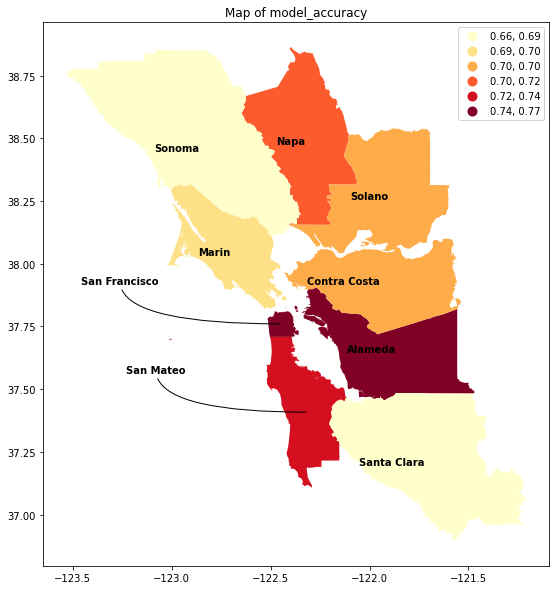

In [52]:
ax = bay_area_counties.plot(column="model_accuracy", figsize=(10,10), legend=True, cmap="YlOrRd", scheme="quantiles", k=6)
plt.title(f"Map of model_accuracy")
for index, row in bay_area_counties.iterrows():
    if row["county"] in ["San Francisco", "San Mateo"]:
        plt.annotate(text=row['county'], xy=row["coords"], xytext=row["coords"], horizontalalignment='right', verticalalignment='bottom', 
                     weight='bold', arrowprops=dict(arrowstyle="-",
                            connectionstyle="angle3"), textcoords='offset points')
    elif row["county"] in ["Contra Costa", "Santa Clara"]:
        plt.annotate(text=row['county'], xy=row["coords"], horizontalalignment='right', verticalalignment='bottom', weight='bold')
    else:
        plt.annotate(text=row['county'], xy=row["coords"], horizontalalignment='right', verticalalignment='top', weight='bold')
#plt.savefig("bay_area_counties_results.png", bbox_inches='tight')

In [53]:
santa_clara = crashes[crashes["county_location"] == "santa clara"].reset_index(drop=True)

In [54]:
contra_costa.shape, santa_clara.shape

((9324, 78), (14006, 78))